# Hands on: Molecule

## step 0: build environment & generate some samples

clone FlowMol: https://github.com/Dunni3/FlowMol

follow FlowMol README ``Environment Setup`` to setup environment

note: if you encounter ``==> For changes to take effect, close and re-open your current shell. <==``, simply ``bash`` in your terminal will refresh.

note: the official ``build_env.sh`` has come dependency issues when installing ``rdkit``, the following provides a quick fix

1. change ``requires-python = ">=3.10,<3.12"`` in pyproject.toml under FlowMol
2. change python version when creating environment, ``mamba create -n flowmol python=3.11.0``
3. replace ``FlowMol/build_env.sh`` under ``build_env.sh`` in this folder and go to ``FlowMol/``
4. ``mamba activate flowmol``
5. ``bash build_env.sh``0  0  0.

follow FlowMol README ``Datasets`` to download and prepare data

note: there are some inconsistent folder/file names between the downloaded and used, which can be easily fixed

after processing QM9 data, comment out line 142 in ``flowmol/models/flowmol.py`` since you are not required to train the model

then run ``python test.py --model_dir trained_models/qm9_ctmc/ --n_mols 100 --n_timesteps 100`` to generate 100 samples

the samples will be saved at ``trained_models/qm9_ctmc/samples/sampled_mols.sdf``

run ``head trained_models/qm9_ctmc/samples/sampled_mols.sdf`` to see a few lines. it will display something like

```
     RDKit          3D

 23 23  0  0  0  0  0  0  0  0999 V2000
    0.2013    1.0705    1.1532 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1262    0.5475    1.1119 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.3767   -0.2953   -3.3973 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.0554   -2.4581   -0.7065 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0741   -0.9779    1.1011 C   0  0  0  0  0  0  0  ...      
```

## step 1: load rdkit molecules

if you are using jypterhub, run ``pip install ipykernel`` and ``python -m ipykernel install --user --name flowmol --display-name "flowmol"`` to register kernel

refresh jupyterhub, reopen demo.ipynb, select kernel ``flowmol``

In [1]:
from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')
import pickle as pkl
import torch
from tqdm import tqdm

# change to your path
path = '../../FlowMol/trained_models/qm9_ctmc/samples/sampled_mols.sdf'

supplier = Chem.SDMolSupplier(path)

mols = [mol for mol in supplier]
print(f'{len(mols)} mols loaded')

100 mols loaded


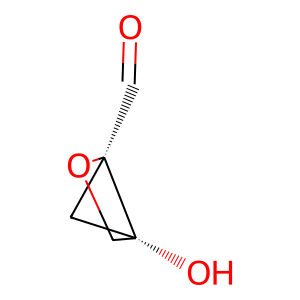

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import py3Dmol
from IPython.display import display

# show 2d mol
mol = mols[0]
img = Draw.MolToImage(mol, size=(300, 300))
display(img)

# show 3d mol
mb = Chem.MolToMolBlock(mol)
viewer = py3Dmol.view(width=400, height=400)
viewer.addModel(mb, 'mol')
viewer.setStyle({'stick': {}})
viewer.zoomTo()
viewer.show()

## step 2: instance-level evaluation

In [3]:
from tqdm import tqdm
from collections import Counter
import numpy as np
from rdkit.Chem import AllChem
from copy import deepcopy

# https://github.com/Dunni3/FlowMol/issues/12
allowed_bonds = {'H': {0: 1, 1: 0},
                 'C': {0: 4},
                 'N': {0: 3, 1: 4, -1: 2},  
                 'O': {0: 2, 1: 3, -1: 1},
                 'F': {0: 1, -1: 0},
                 'B': 3, 'Al': 3, 'Si': 4,
                 'P': {0: [3, 5], 1: 4},
                 'S': {0: [2, 6], 1: [2, 3], 2: 4, 3: 5, -1: 3},
                 'Cl': 1, 'As': 3,
                 'Br': {0: 1, 1: 2}, 'I': 1, 'Hg': [1, 2], 'Bi': [3, 5], 'Se': [2, 4, 6]}
bond_dict = [None, Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE,
             Chem.rdchem.BondType.AROMATIC]

def check_stability(mol):
    atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
    valencies = [atom.GetTotalValence() for atom in mol.GetAtoms()]
    charges = [atom.GetFormalCharge() for atom in mol.GetAtoms()]

    n_stable_atoms = 0
    mol_stable = True
    for i, (atom_type, valency, charge) in enumerate(zip(atom_types, valencies, charges)):
        valency = int(valency)
        charge = int(charge)
        possible_bonds = allowed_bonds[atom_type]
        if type(possible_bonds) == int:
            is_stable = possible_bonds == valency
        elif type(possible_bonds) == dict:
            expected_bonds = possible_bonds[charge] if charge in possible_bonds.keys() else possible_bonds[0]
            is_stable = expected_bonds == valency if type(expected_bonds) == int else valency in expected_bonds
        else:
            is_stable = valency in possible_bonds
        if not is_stable:
            mol_stable = False
        n_stable_atoms += int(is_stable)

    return n_stable_atoms, mol_stable, atom_types


def check_validity(mol):
    valid = False
    complete = False
    
    if mol is None:
        return False
    
    mol_frags = Chem.rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    n_frags = len(mol_frags)

    if n_frags == 1:
        complete = True

    try:
        Chem.SanitizeMol(mol)
        smiles = Chem.MolToSmiles(mol)
        valid = True
    except Error as e:
        print(e)

    return valid and complete


def get_molecule_force_field(mol, conf_id=None, force_field='mmff', **kwargs):
    """
    Get a force field for a molecule.
    Parameters
    ----------
    mol : RDKit Mol
        Molecule.
    conf_id : int, optional
        ID of the conformer to associate with the force field.
    force_field : str, optional
        Force Field name.
    kwargs : dict, optional
        Keyword arguments for force field constructor.
    """
    if force_field == 'uff':
        ff = AllChem.UFFGetMoleculeForceField(
            mol, confId=conf_id, **kwargs)
    elif force_field.startswith('mmff'):
        AllChem.MMFFSanitizeMolecule(mol)
        mmff_props = AllChem.MMFFGetMoleculeProperties(
            mol, mmffVariant=force_field)
        ff = AllChem.MMFFGetMoleculeForceField(
            mol, mmff_props, confId=conf_id, **kwargs)
    else:
        raise ValueError("Invalid force_field {}".format(force_field))
    return ff


def get_conformer_energies(mol, force_field='mmff'):
    """
    Calculate conformer energies.
    Parameters
    ----------
    mol : RDKit Mol
        Molecule.
    force_field : str, optional
        Force Field name.
    Returns
    -------
    energies : array_like
        Minimized conformer energies.
    """
    energies = []
    for conf in mol.GetConformers():
        ff = get_molecule_force_field(mol, conf_id=conf.GetId(), force_field=force_field)
        energy = ff.CalcEnergy()
        energies.append(energy)
    energies = np.asarray(energies, dtype=float)
    return energies


def evaluate(mols):
    n_atoms = 0
    n_stable_atoms = 0
    n_stable_mols = 0
    n_mols = 0

    n_valid_mols = 0
    n_complete_mols = 0
    n_valid_and_complete_mols = 0

    all_atom_types = []
    valid_mols = []
    all_energy = []
    all_smiles = []

    for mol in tqdm(mols, ncols=100):
        if mol is None:
            continue

        n_mols += 1
            
        n_atoms += mol.GetNumAtoms()
        _n_stable_atoms, _mol_stable, _atom_types = check_stability(mol)
        n_stable_atoms += _n_stable_atoms
        n_stable_mols += int(_mol_stable)
        all_atom_types.extend(_atom_types)
        
        try:
            Chem.SanitizeMol(mol)
            smiles = Chem.MolToSmiles(mol)
            _mol_valid = True

            mol_frags = Chem.rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
            n_frags = len(mol_frags)
            _mol_complete = n_frags == 1

            n_valid_mols += int(_mol_valid)
            n_complete_mols += int(_mol_complete)
            n_valid_and_complete_mols += int(_mol_valid and _mol_complete)

            if not (_mol_valid and _mol_complete):
                continue

            valid_mols.append(mol)
            all_smiles.append(smiles)

            energy = get_conformer_energies(mol)
            all_energy.append(energy)
        except Exception as e:
            print(e)

    frac_atom_stable = n_stable_atoms / n_atoms
    frac_mol_stable = n_stable_mols / n_mols
    frac_mol_valid = n_valid_mols / n_mols
    frac_mol_complete = n_complete_mols / n_mols
    frac_mol_valid_and_complete = n_valid_and_complete_mols / n_mols

    print(f'avg mol size: {n_atoms / n_mols:.2f}')
    print(f'atom stable: {frac_atom_stable:.2f}, mol stable: {frac_mol_stable:.2f}')
    print(f'valid: {frac_mol_valid:.2f}, complete: {frac_mol_complete:.2f}, valid and complete: {n_valid_and_complete_mols:.2f}')

    all_energy = np.array(all_energy)
    all_energy = all_energy[~np.isnan(all_energy)]
    mean_energy = np.mean(all_energy)

    print(f'mean mmff energy: {mean_energy:.2f} from {len(all_energy)} mols')

    unique = len(set(all_smiles)) / len(all_smiles)
    print(f'unique: {unique:.2f}')

    return valid_mols, all_smiles, all_energy, all_atom_types

valid_mols, all_smiles, all_energy, all_atom_types = evaluate(mols)
print(f'{len(valid_mols)} valid mols')

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1962.43it/s]

avg mol size: 8.48
atom stable: 1.00, mol stable: 0.99
valid: 1.00, complete: 1.00, valid and complete: 97.00
mean mmff energy: 24.14 from 97 mols
unique: 1.00
97 valid mols


## step 3: distribution-evel evaluation

In [4]:
import matplotlib.pyplot as plt
from rdkit import DataStructs

def tanimoto_sim(mol, ref):
    fp1 = Chem.RDKFingerprint(ref)
    fp2 = Chem.RDKFingerprint(mol)
    return DataStructs.TanimotoSimilarity(fp1,fp2)

def tanimoto_dis(mol, ref):
    return 1 - tanimoto_sim(mol, ref)

def tanimoto_dis_N_to_1(mols, ref):
    sim = [tanimoto_dis(m, ref) for m in mols]
    return sim

def compute_diversity(mols):
    diversity = []
    for j in range(len(mols)):
        tmp = tanimoto_dis_N_to_1(mols, mols[j])
        tmp.pop(j)
        diversity += tmp
    diversity = np.array(diversity)
    print('[Diversity] Avg: %.4f | Med: %.4f ' % (np.mean(diversity), np.median(diversity)))
    return diversity

diversity = compute_diversity(valid_mols)


[Diversity] Avg: 0.8746 | Med: 0.8927 


In [5]:
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    mol = Chem.RemoveHs(mol)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
    return smiles

train_smiles = []
for s in tqdm(pkl.load(open(f'../../FlowMol/data/qm9_valid/train_data_smiles.pkl', 'rb')), ncols=100):
    s = canonical_smiles(s)
    train_smiles.append(s)

test_smiles = []
for s in tqdm(pkl.load(open(f'../../FlowMol/data/qm9_valid/test_data_smiles.pkl', 'rb')), ncols=100):
    s = canonical_smiles(s)
    test_smiles.append(s)

print(f'{len(train_smiles)} train smiles, {len(test_smiles)} test smiles')
print(test_smiles[:3])

test_smiles = set(test_smiles)
test_mols = {}
for mol in tqdm(Chem.SDMolSupplier('../../FlowMol/data/qm9_raw/gdb9.sdf'), ncols=100):
    if mol is None: continue
    mol = Chem.RemoveHs(mol)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
    if smiles in test_smiles:
        test_mols[smiles] = mol
print(len(test_smiles), len(test_mols))

100%|██████████████████████████████████████████████████████| 12930/12930 [00:01<00:00, 11111.66it/s]


96663 train smiles, 12930 test smiles
['O', 'CC#CC', 'COC=O']


100%|█████████████████████████████████████████████████████| 133885/133885 [00:20<00:00, 6457.82it/s]

12927 12927


In [6]:
def compute_novelty(ref_smiles, sample_smiles):
    samples = set(sample_smiles)
    ref_smiles = set(ref_smiles)
    return len(samples - ref_smiles) / len(sample_smiles)

novelty = compute_novelty(train_smiles, all_smiles)
print(f'novelty: {novelty:.2f}')

novelty: 0.93


100%|███████████████████████████████████████████████████████| 12927/12927 [00:03<00:00, 4149.16it/s]


24.143660178958726 23.984666067055244


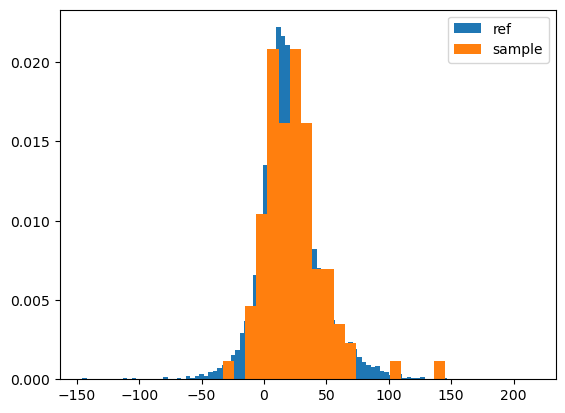

In [7]:
ref_energy = []
for mol in tqdm(test_mols.values(), ncols=100):
    energy = get_conformer_energies(mol)
    ref_energy.append(energy)
ref_energy = np.array(ref_energy)
ref_energy = ref_energy[~np.isnan(ref_energy)]

print(np.mean(all_energy), np.std(all_energy))
plt.hist(ref_energy, density=True, bins=100, label='ref')
plt.hist(all_energy, density=True, bins=20, label='sample')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████| 12927/12927 [00:00<00:00, 22973.16it/s]


Counter({'C': 82128, 'O': 18024, 'N': 13192, 'F': 291, 'H': 116})
{'O': 0.15845135427380858, 'C': 0.7219980483688055, 'N': 0.11597260683422564, 'H': 0.0010197712547581998, 'F': 0.002558219268402036}
Counter({'C': 636, 'O': 124, 'N': 60, 'F': 3})
{'C': 0.772782503037667, 'O': 0.15066828675577157, 'N': 0.07290400972053462, 'F': 0.0036452004860267314}


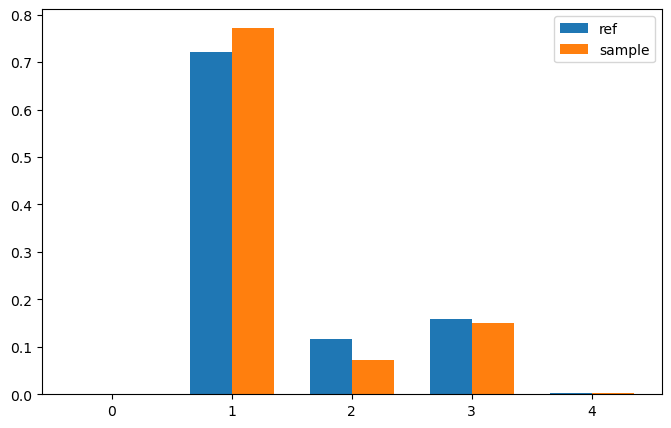

In [8]:
ref_atom_types = []
for mol in tqdm(test_mols.values(), ncols=100):
    mol = Chem.RemoveHs(mol)
    atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
    ref_atom_types.extend(atom_types)

counter = Counter(ref_atom_types)
print(counter)
ref_ratio = {k: v/sum(counter.values()) for k, v in counter.items()}
print(ref_ratio)

counter = Counter(all_atom_types)
print(counter)
sample_ratio = {k: v/sum(counter.values()) for k, v in counter.items()}
print(sample_ratio)

all_elements = ['H', 'C', 'N', 'O', 'F']

freq1 = [ref_ratio.get(el, 0) for el in all_elements]
freq2 = [sample_ratio.get(el, 0) for el in all_elements]

x = np.arange(len(all_elements))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, freq1, width, label='ref')
plt.bar(x + width/2, freq2, width, label='sample')
plt.legend()
plt.show()